In [16]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [17]:
NO_POSITIONS = 50
NO_EXP_PER_POSITION = 50

In [18]:
def calculate_volume_flow_lpm(gas_flow_number, froude_number, d_stirrer=0.095, d_reactor=0.3):
    rps = math.sqrt(froude_number*9.81/d_stirrer)
    volume_flow_m3_per_sec = gas_flow_number * rps * (d_stirrer ** 3)
    volume_flow_lpm = volume_flow_m3_per_sec * 60 * 1000
    return volume_flow_lpm

def calculate_rpm(froude_number, d_stirrer=0.095, d_reactor=0.3):
    rps = math.sqrt(froude_number*9.81/d_stirrer)
    rpm = rps * 60
    return rpm

def calculate_gas_flow_number(volume_flow_lpm, rpm, d_stirrer=0.095):
    volume_flow_m3_per_sec = volume_flow_lpm / 60 / 1000
    rps = rpm / 60
    return volume_flow_m3_per_sec / (rps * d_stirrer**3)

def calculate_froude_number(rpm, d_stirrer=0.095):
    rps = rpm / 60
    return rps**2 * d_stirrer / 9.81

def flow_regime(gas_flow_number, froude_number):
    if np.log10(froude_number) >= np.interp(np.log10(gas_flow_number), np.log10([0.002, 0.2]), np.log10([0.2, 2.0])):
        return 2
    elif np.log10(froude_number) <= np.interp(np.log10(gas_flow_number), np.log10([0.013, 1]), np.log10([0.02, 1.4])):
        return 0
    else:
        return 1


calculate_rpm(1, d_stirrer=0.095, d_reactor=0.3)

609.710889209839

In [19]:
from pydantic import BaseModel

class Coordinates(BaseModel):
    x: float
    y: float
    z: float
    yaw: float=None

def calculate_arc(camera_position, distance_to_center, angle_min, angle_max, no_points):
    angles = np.linspace(angle_min, angle_max, no_points)
    return [Coordinates(x=camera_position.x + distance_to_center - distance_to_center*np.cos(angle* np.pi / 180.),
                          y=camera_position.y + distance_to_center*np.sin(angle* np.pi / 180.),
                          z=camera_position.z,
                          yaw=angle) for angle in angles]

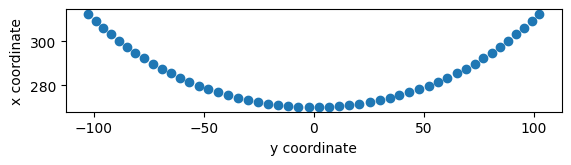

In [20]:
camera_position = Coordinates(x=270, y=0, z=467)
distance_to_center = 145
angle_min = -45
angle_max = 45
arc_points = calculate_arc(camera_position, distance_to_center, angle_min, angle_max, NO_POSITIONS)
points_x = [point.x for point in arc_points]
points_y = [point.y for point in arc_points]
points_z = [point.z for point in arc_points]
points_yaw = [point.yaw for point in arc_points]
arc_points_df = pd.DataFrame(list(zip(points_x, points_y, points_z, points_yaw)), columns=['x', 'y', 'z', 'yaw'])
plt.scatter(points_y, points_x)
plt.xlabel('y coordinate')
plt.ylabel('x coordinate')
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.show()

In [21]:
from modules.smart_camera import SmartCamera

if False:
    point_to_check = 2
    smart_camera = SmartCamera()
    smart_camera.smart_camera.connect()
    smart_camera.camera_positioning_run(x=arc_points[point_to_check].x,
                                        y=arc_points[point_to_check].y,
                                        z=arc_points[point_to_check].z,
                                        yaw=arc_points[point_to_check].yaw)
    smart_camera.smart_camera.disconnect()

In [22]:
def create_doe(flowrate_min, flowrate_max, rpm_min, rpm_max, total_no_points):
    return np.random.uniform(low=[flowrate_min, flowrate_max], high=[rpm_min, rpm_max], size=(total_no_points,2))

In [23]:
flow_map_data = create_doe({flowrate_min = 1.5,
flowrate_max = 100,
rpm_min = 100,
rpm_max = 1000,}
                      total_no_points=NO_EXP_PER_POSITION)

flow_map = pd.DataFrame(data=flow_map_data, columns=['Volume flow rate', 'Stirrer speed'])
flow_map['Gas flow number'] = flow_map.apply(lambda x: calculate_gas_flow_number(x['Volume flow rate'], x['Stirrer speed']), axis=1)
flow_map['Froude number'] = flow_map.apply(lambda x: calculate_froude_number(x['Stirrer speed']), axis=1)
flow_map['Flow regime'] = flow_map.apply(lambda x: flow_regime(x['Gas flow number'], x['Froude number']), axis=1)
flow_map.reset_index(inplace=True)

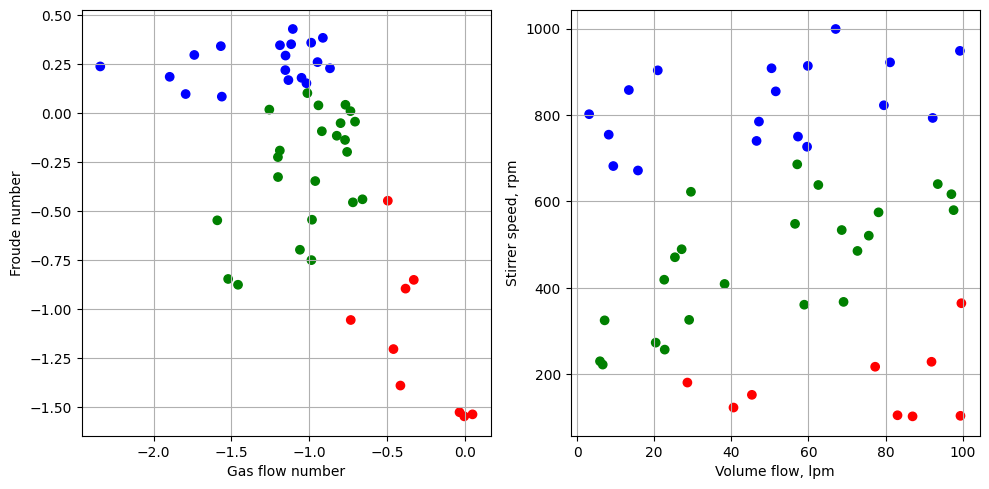

In [24]:
fig=plt.figure(figsize=(10,5))
(ax1, ax2) = fig.subplots(1, 2)

colors = {0:'red', 1:'green', 2:'blue'}

ax1.scatter(np.log10(flow_map['Gas flow number']), np.log10(flow_map['Froude number']), c=flow_map['Flow regime'].map(colors))
ax1.grid(True, which="both")
ax1.set_xlabel('Gas flow number')
ax1.set_ylabel('Froude number')

ax2.scatter(flow_map['Volume flow rate'], flow_map['Stirrer speed'], c=flow_map['Flow regime'].map(colors))
ax2.grid(True, which="both")
ax2.set_xlabel('Volume flow, lpm')
ax2.set_ylabel('Stirrer speed, rpm')

fig.tight_layout()
plt.show()

In [25]:
doe = arc_points_df.merge(flow_map, how='cross')
doe.to_csv('doe.csv')